In [1]:
import pandas as pd
import requests
import plotly.express as px

data = requests.get("https://data.calgary.ca/resource/c2es-76ed.json")
df = pd.DataFrame(data.json())
for col in ['applieddate', 'issueddate', 'completeddate']:
    df[col] = pd.to_datetime(df[col])
df["year"] = df.issueddate.dt.year
df = df[(df.year > 2010) & (df.year < 2024)]

post_covid = df[df.year >= 2020]
pre_covid = df[(df.year < 2020) & (df.year >= 2010)]


In [2]:

labels = {
    'tti': "Days to Approval",
    'ttc': "Days to Complete(After Permit Issue)",
    'totaltime': "Days to Complete(Total)",
    'costperdaytotal': "Revenue Per Day (since Applied)",
    'costperday': "Revenue Per Day (since issued)",
    'year': 'Year',
    'workclass': "Work Class",
    'contractorname': 'Contractor',
    'permitnum': 'Number of Permits',
    'permittype': 'Type of Permits',
}

### Overview
There is a dip in activity in 2020 due to restrictions. Looking at the difference there didn't seem 
to be much change in distribution geographically or in the type of work after the dip.

The notable findings are that there are a large number of permits issued for additions and new 
construction. However, this work does not have high revenue potential. The highest revenue potential
and the quickest to complete have been alterations.

Most of the work available is in the commercial space with demolitions being second and residential 
only accounted for a few permits each year.

***NOTE***: 2024 numbers are lower than other years because that year includes some permits for works 
that have not been completed yet.


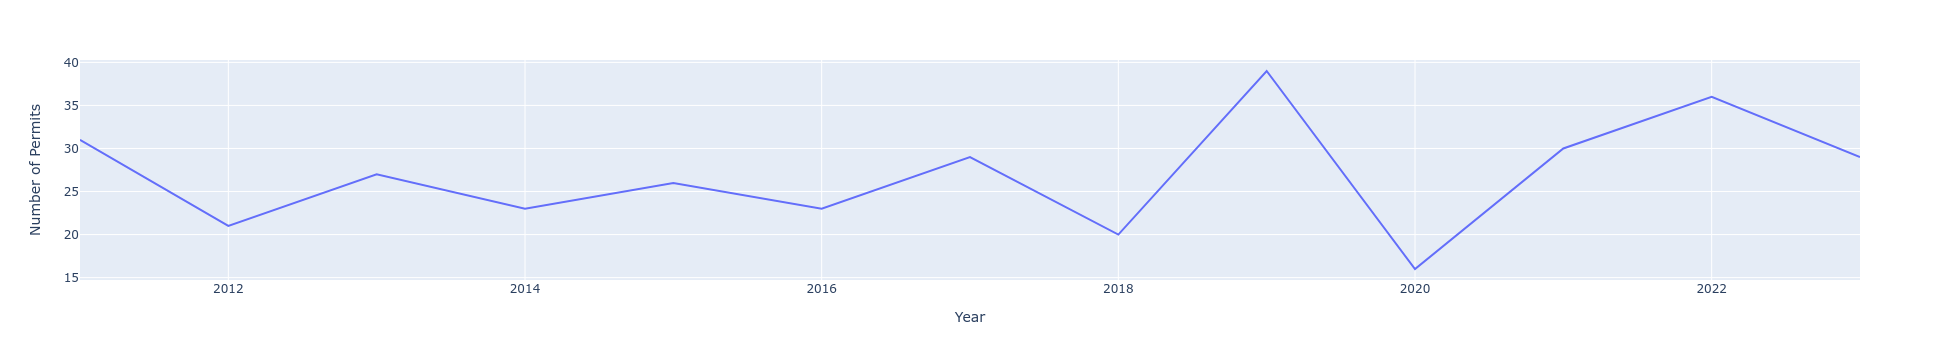

In [3]:
yearly_permits = df.groupby("year")[["permitnum"]].count().reset_index()
px.line(yearly_permits, y="permitnum", x="year", labels=labels)

#### Acteve Contractors

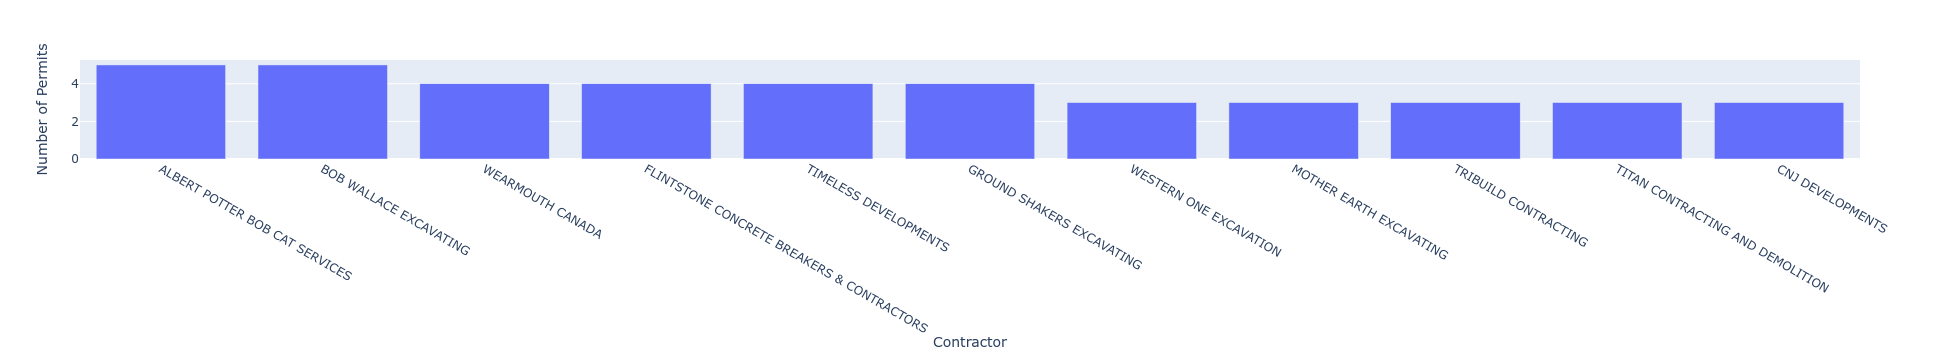

In [4]:
contractor_permits = df[df.year > 2010].groupby("contractorname")["permitnum"].count().sort_values(ascending=False)
contractors_top = contractor_permits[contractor_permits > 2]
px.bar(contractors_top, y='permitnum', labels=labels)


## Types of works

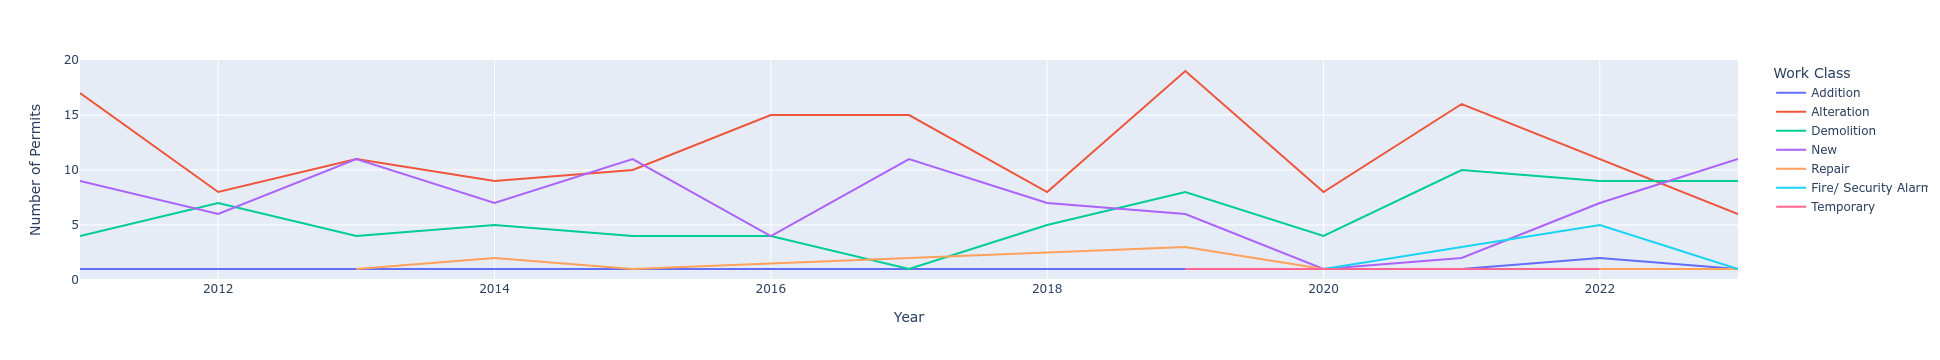

In [5]:
px.line(df.groupby(["year", "workclass"]).permitnum.count().reset_index(), x='year', y='permitnum', color='workclass', labels=labels)

New construction is now catching up to pre-2020 levels.

At the same time, alterations are in a slight decline.

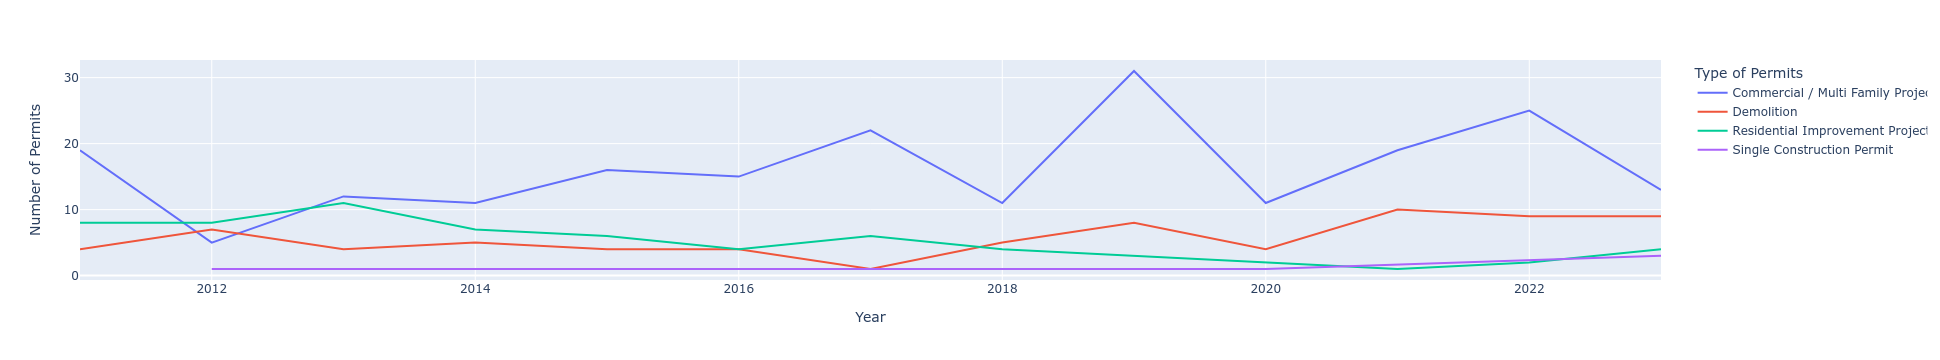

In [6]:
px.line(df.groupby(["year", "permittype"]).permitnum.count().reset_index(), x='year', y='permitnum', color='permittype', labels=labels)

### Time To Approve

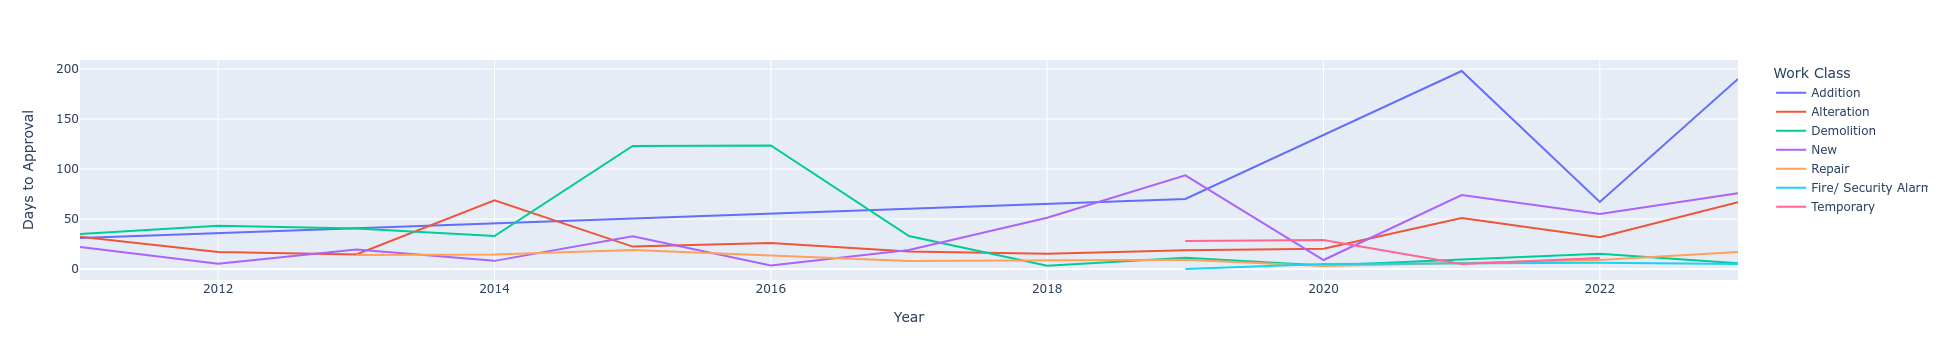

In [7]:
df["tti"] = (df.issueddate - df.applieddate).dt.days
px.line(df.groupby(["year", "workclass"]).tti.mean().reset_index(), x='year', y='tti', color='workclass', labels=labels)


It looks like additions are taking a long time to approve. New work and alterations permits have a quicker time to approve time.



### Turnaround


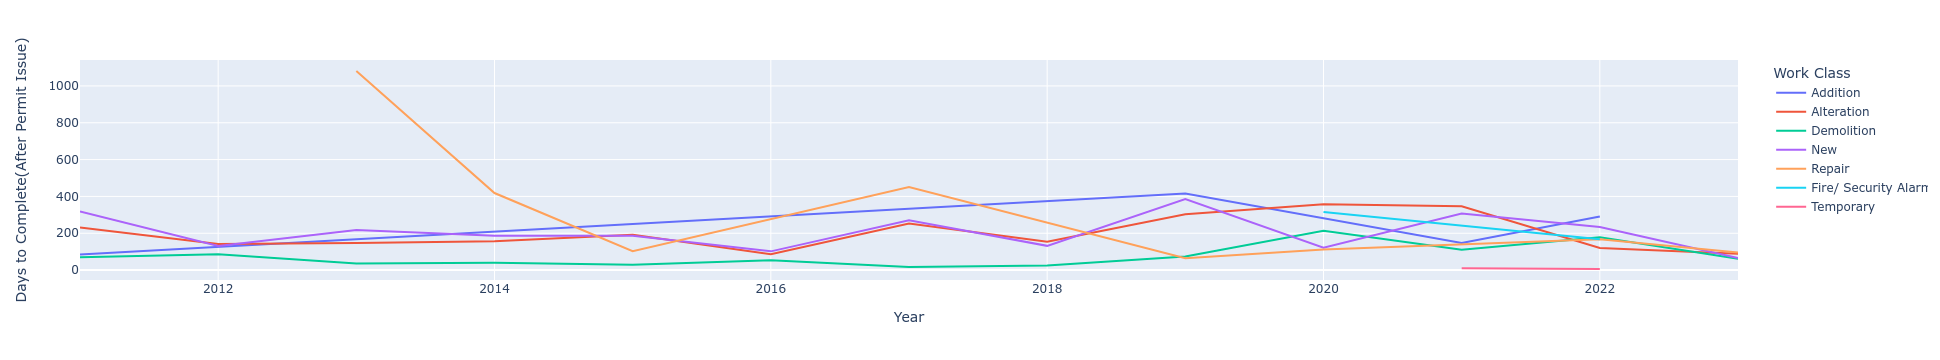

In [17]:
df["ttc"] = (df.completeddate - df.issueddate).dt.days
px.line(df.groupby(["year", "workclass"]).ttc.mean().reset_index(), x='year', y='ttc', color='workclass', labels=labels)

***NOTE***: A large number of permits issued in 2023 have not been completed

Alterations continue to be on the lower end of time to complete.

### Total

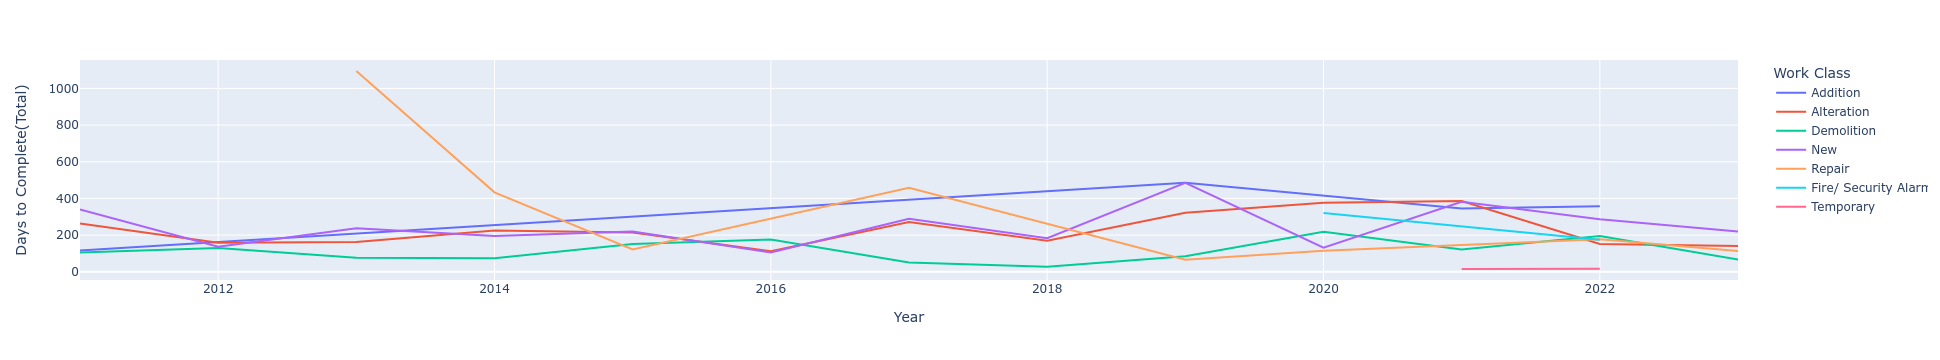

In [20]:
df["totaltime"] = (df.completeddate - df.applieddate).dt.days
px.line(df.groupby(["year", "workclass"]).totaltime.mean().reset_index(), x='year', y='totaltime', color='workclass', labels=labels)

***NOTE***: Some permits issued in 2023 have not been completed


### Revenue

In [71]:
df_rev = df[["year", "workclass", "estprojectcost", "issueddate", "completeddate", "applieddate", "totaltime", "ttc", "permitnum"]].dropna()

#### Revenue per day

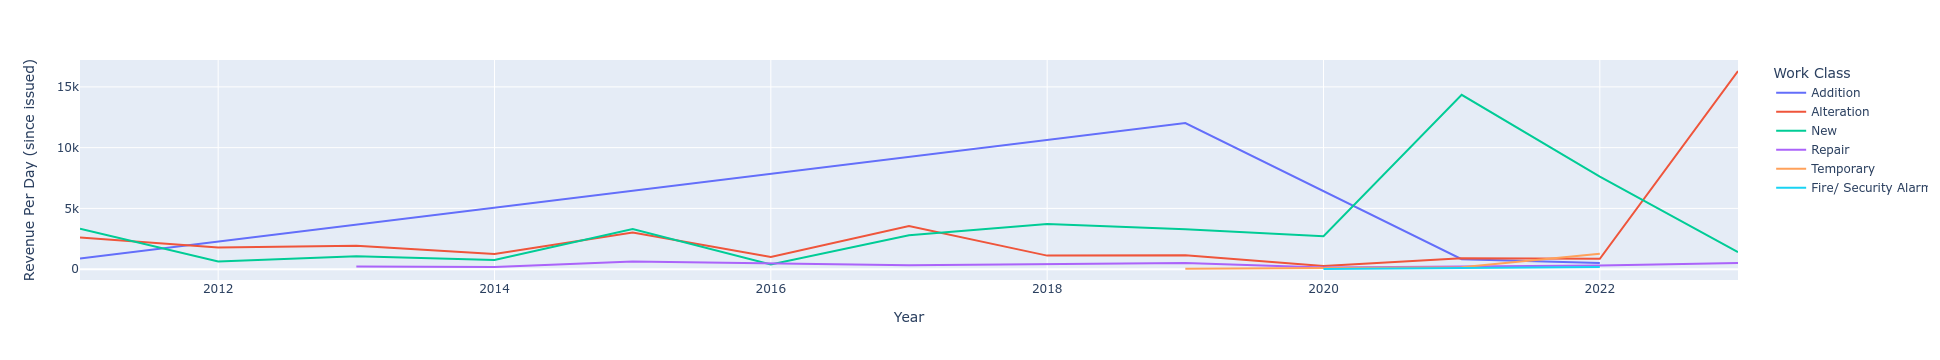

In [72]:
df_rev["costperday"] = df_rev.estprojectcost.astype(float)/df_rev.ttc
px.line(df_rev.groupby(["year", "workclass"]).costperday.mean().reset_index(), x='year', y='costperday', color='workclass', labels=labels)

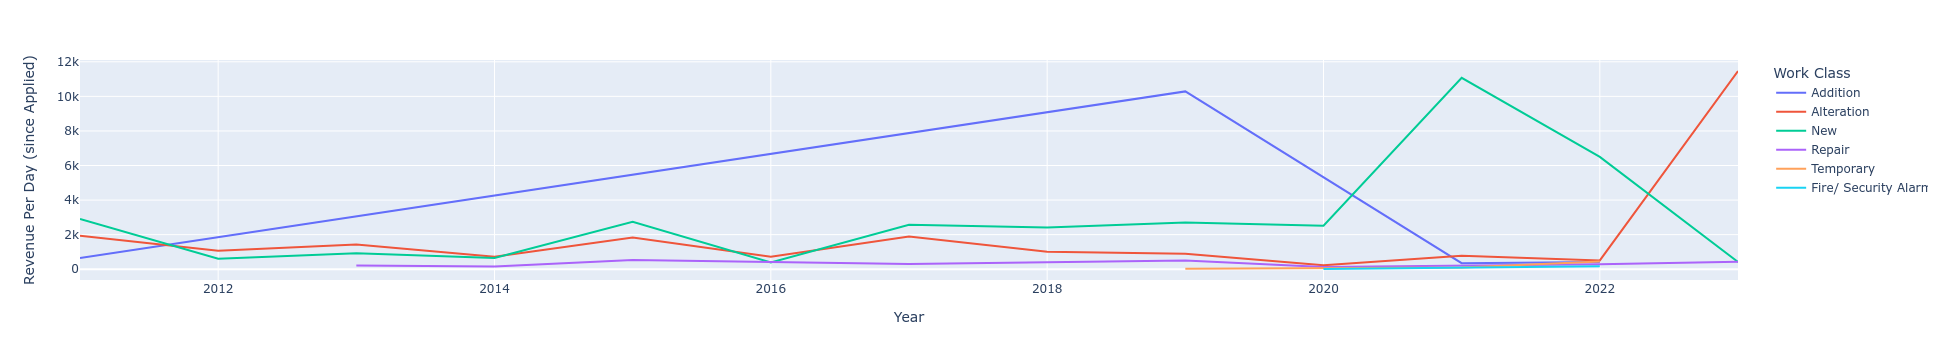

In [73]:
df_rev["costperdaytotal"] = df_rev.estprojectcost.astype(float)/df_rev.totaltime
px.line(df_rev.groupby(["year", "workclass"]).costperdaytotal.mean().reset_index(), x='year', y='costperdaytotal', color='workclass', labels=labels)

Alterations seem to have a quick turnaround aid high revenue.

#### Revenue VS Time to Complete

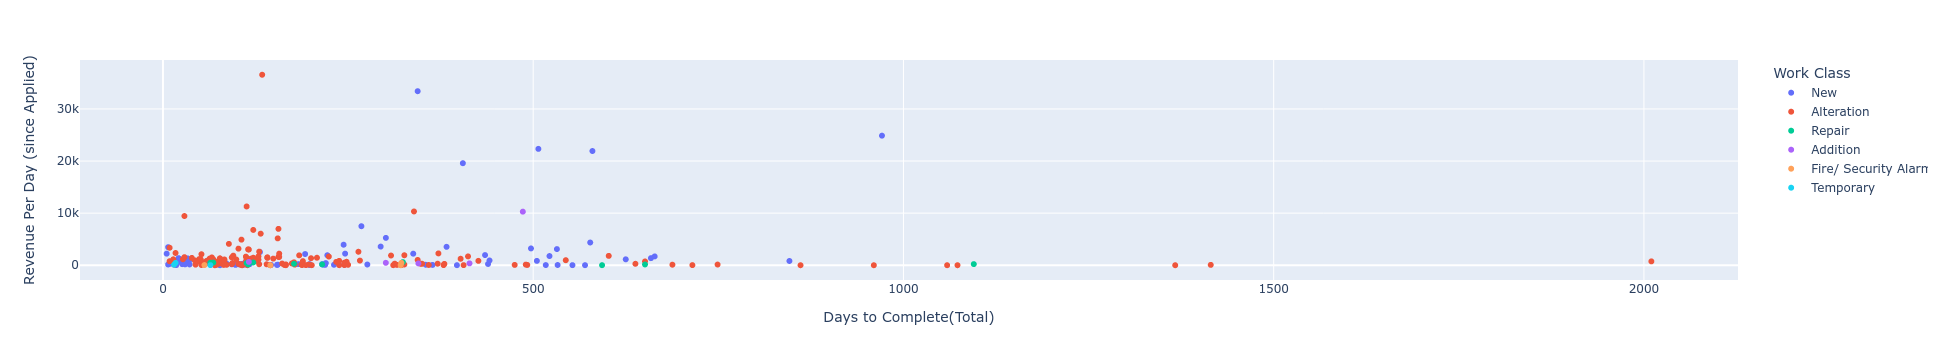

In [79]:
px.scatter(df_rev, x="totaltime", y="costperdaytotal", color="workclass", hover_data=["permitnum", "year"], labels={**labels, "permitnum": "Permit Number"})

Revenue vs turnround seems to show that Alterations have a high possibility for both revenue and throughput of projects.
This could be good for sustaining an effort to introduce your brand to a new market by spreading word of mouth about your company.

# Active communities

In [29]:
pre_covid_work_per_community = pre_covid.groupby(pre_covid.communityname)[["permitnum"]].count()
pre_covid_work_per_community["works_per_year"] = pre_covid_work_per_community/(2020-2010)
pre_covid_active_communities = pre_covid_work_per_community[pre_covid_work_per_community.permitnum > 3]

post_covid_work_per_community = pd.DataFrame(post_covid.groupby(post_covid.communityname)["permitnum"].count())
post_covid_work_per_community["works_per_year"] = post_covid_work_per_community/(2024-2020)
post_covid_active_communities = post_covid_work_per_community[post_covid_work_per_community.permitnum >= 2]

active_communities = set()
active_communities.update(pre_covid_active_communities.index.unique())
active_communities.update(post_covid_active_communities.index.unique())
c = dict(zip(active_communities, px.colors.qualitative.Alphabet))

### Pre 2020

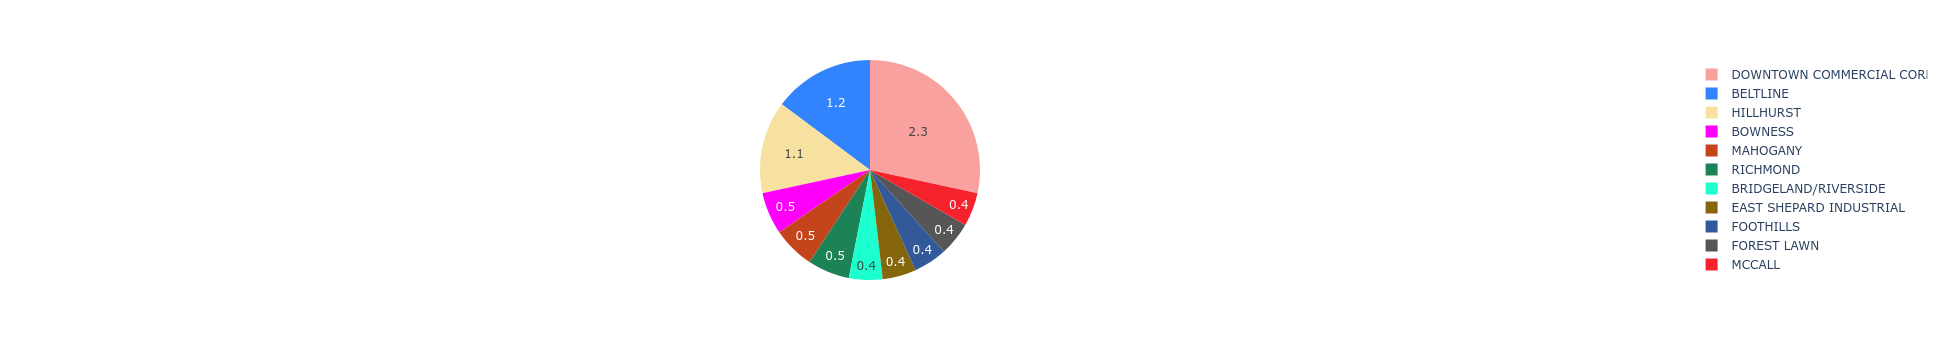

In [30]:
fig = px.pie(pre_covid_active_communities, values="works_per_year", names=pre_covid_active_communities.index, color=pre_covid_active_communities.index, color_discrete_map=c)
fig.update_traces(textinfo='value')
fig

### After 2020

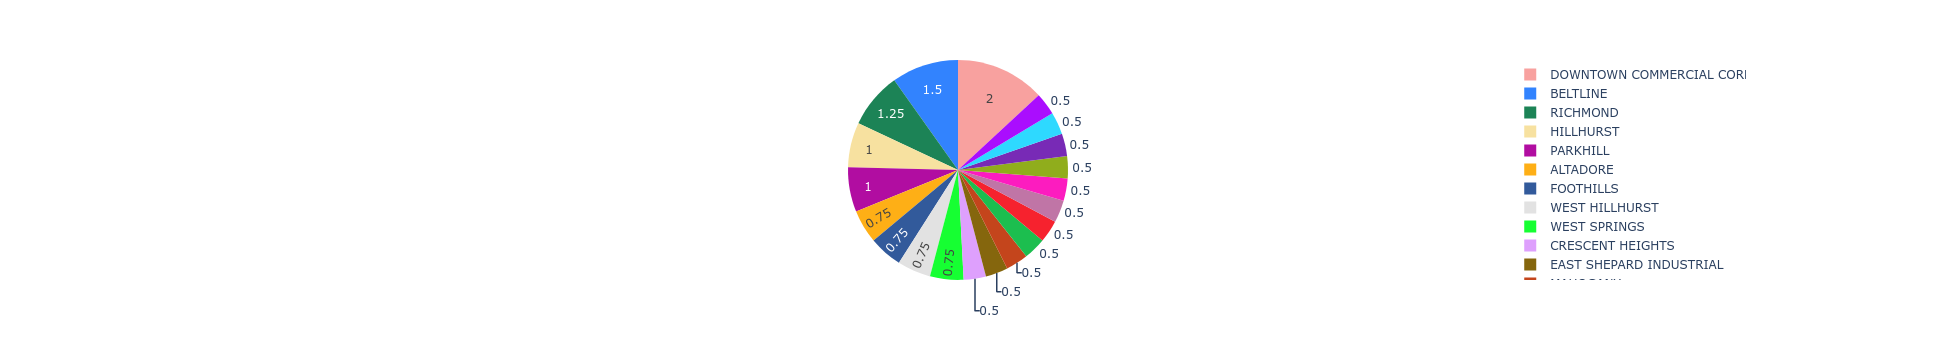

In [31]:
fig = px.pie(post_covid_active_communities, values="works_per_year", names=post_covid_active_communities.index, color=post_covid_active_communities.index, color_discrete_map=c)
fig.update_traces(textinfo='value')
fig

The downtown core continues to see activity. 

Atladore and Parkhill have seen a sharp increase in recent years.
As well as several smaller communities have had more than one 
permit for work in the last 4 years.